In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 8s 1s/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 28ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [==============================] -

8/8 [==============================] - 0s 30ms/step - loss: 11.8514 - mae: 12.4808
Epoch 88/100
8/8 [==============================] - 0s 32ms/step - loss: 10.6505 - mae: 11.1409
Epoch 89/100
8/8 [==============================] - 0s 28ms/step - loss: 11.4433 - mae: 11.6524
Epoch 90/100
8/8 [==============================] - 0s 32ms/step - loss: 9.2392 - mae: 9.6925
Epoch 91/100
8/8 [==============================] - 0s 29ms/step - loss: 14.1725 - mae: 13.3609
Epoch 92/100
8/8 [==============================] - 0s 27ms/step - loss: 21.8322 - mae: 22.7096
Epoch 93/100
8/8 [==============================] - 0s 25ms/step - loss: 14.3810 - mae: 15.1494
Epoch 94/100
8/8 [==============================] - 0s 24ms/step - loss: 17.4896 - mae: 16.9670
Epoch 95/100
8/8 [==============================] - 0s 24ms/step - loss: 18.3393 - mae: 19.0691
Epoch 96/100
8/8 [==============================] - 0s 24ms/step - loss: 13.3849 - mae: 13.8388
Epoch 97/100
8/8 [==============================] - 0s 

(1e-08, 0.0001, 0.0, 30.0)

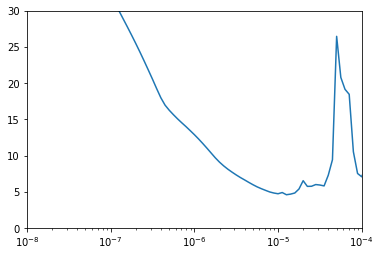

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 101ms/step - loss: 21.5797 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 6.6130 - mae: 7.1068
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 7.0604 - mae: 7.5344
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 6.0318 - mae: 6.5210
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 5.6411 - mae: 6.1250
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 5.4648 - mae: 5.9449
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 5.3321 - mae: 5.8048
Epoch 9/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2409 - mae: 5.7336
Epoch 10/500
31/31 [==============================] - 0s 9ms/step - loss: 5.2127 - mae: 5.6968
Epoch 11/500
31/31 [==============================] -

31/31 [==============================] - 0s 9ms/step - loss: 4.4421 - mae: 4.9244
Epoch 87/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2371 - mae: 4.7124
Epoch 88/500
31/31 [==============================] - 0s 10ms/step - loss: 4.3259 - mae: 4.7995
Epoch 89/500
31/31 [==============================] - 0s 10ms/step - loss: 4.2759 - mae: 4.7600
Epoch 90/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2681 - mae: 4.7397
Epoch 91/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1887 - mae: 4.6656
Epoch 92/500
31/31 [==============================] - 0s 11ms/step - loss: 4.2460 - mae: 4.7217
Epoch 93/500
31/31 [==============================] - 0s 9ms/step - loss: 4.2065 - mae: 4.6787
Epoch 94/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1755 - mae: 4.6382
Epoch 95/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1723 - mae: 4.6453
Epoch 96/500
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 9ms/step - loss: 4.2211 - mae: 4.6912
Epoch 172/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0766 - mae: 4.5566
Epoch 173/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0855 - mae: 4.5575
Epoch 174/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0583 - mae: 4.5280
Epoch 175/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0452 - mae: 4.5191
Epoch 176/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1057 - mae: 4.5705
Epoch 177/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1629 - mae: 4.6376
Epoch 178/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0752 - mae: 4.5385
Epoch 179/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0765 - mae: 4.5473
Epoch 180/500
31/31 [==============================] - 0s 9ms/step - loss: 4.3006 - mae: 4.7866
Epoch 181/500
31/31 [==============================] -

31/31 [==============================] - 0s 9ms/step - loss: 3.9754 - mae: 4.4507
Epoch 256/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0278 - mae: 4.5013
Epoch 257/500
31/31 [==============================] - 0s 9ms/step - loss: 4.1015 - mae: 4.5826
Epoch 258/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0981 - mae: 4.5738
Epoch 259/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0663 - mae: 4.5357
Epoch 260/500
31/31 [==============================] - 0s 11ms/step - loss: 4.0027 - mae: 4.4776
Epoch 261/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0510 - mae: 4.5153
Epoch 262/500
31/31 [==============================] - 0s 10ms/step - loss: 4.1010 - mae: 4.5810
Epoch 263/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0573 - mae: 4.5244
Epoch 264/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0525 - mae: 4.5285
Epoch 265/500
31/31 [==============================]

31/31 [==============================] - 0s 9ms/step - loss: 3.9512 - mae: 4.4246
Epoch 341/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0440 - mae: 4.5051
Epoch 342/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0383 - mae: 4.5218
Epoch 343/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0009 - mae: 4.4749
Epoch 344/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9809 - mae: 4.4509
Epoch 345/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0107 - mae: 4.4880
Epoch 346/500
31/31 [==============================] - 0s 10ms/step - loss: 3.9774 - mae: 4.4481
Epoch 347/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9506 - mae: 4.4211
Epoch 348/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9674 - mae: 4.4371
Epoch 349/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9983 - mae: 4.4759
Epoch 350/500
31/31 [==============================] 

31/31 [==============================] - 0s 9ms/step - loss: 3.9279 - mae: 4.3944
Epoch 426/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9609 - mae: 4.4387
Epoch 427/500
31/31 [==============================] - 0s 11ms/step - loss: 3.9256 - mae: 4.4004
Epoch 428/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9879 - mae: 4.4598
Epoch 429/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9763 - mae: 4.4529
Epoch 430/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9459 - mae: 4.4168
Epoch 431/500
31/31 [==============================] - 0s 9ms/step - loss: 4.0015 - mae: 4.4773
Epoch 432/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9399 - mae: 4.4140
Epoch 433/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9350 - mae: 4.4076
Epoch 434/500
31/31 [==============================] - 0s 9ms/step - loss: 3.9680 - mae: 4.4356
Epoch 435/500
31/31 [==============================] 

In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

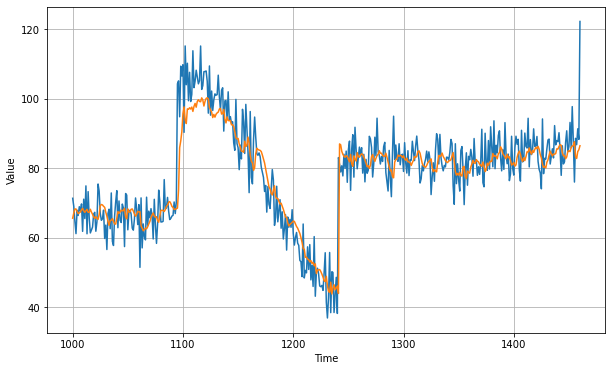

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.9966593

<Figure size 432x288 with 0 Axes>

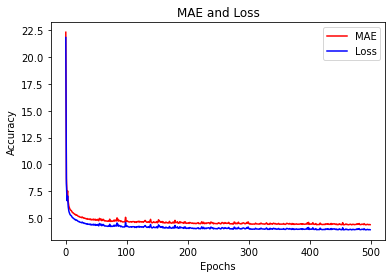

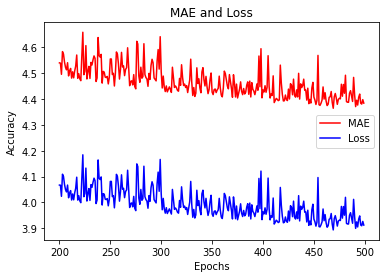

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

<Figure size 432x288 with 0 Axes>

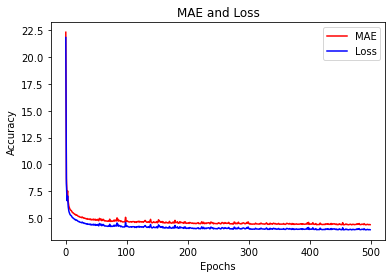

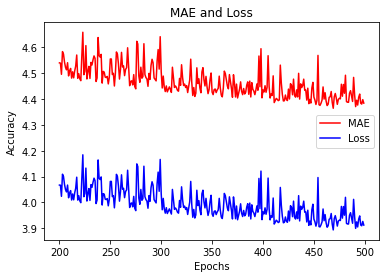

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()